<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
 

<strong>Objectives:</strong>
+ Entender la variable Stock
    
    
<strong>Conclusions:</strong>
+ Cuando hay valor hay dos valores de stock por día (>99% de los casos)
+ La variable stock nunca toma el valor 0
+ Hay 10.528 días sin stock
+ Esos días sin stock están repartidos en 2639 intervalos (momentos seguidos de 1 a n días en los cuales un producto está sin stock)
+ De esos 2639 intervalos, 1085 intervalos son de un día
   
</div>

In [3]:
import os, sys

def get_root_path(search_word):
    """ Búsqueda hacia atrás de un directorio con nombre search_word. """
    cwd = os.getcwd()
    while str(os.getcwd()).split('/')[-1] != search_word:
        os.chdir("..")
        cwd = os.getcwd()
    return cwd

ROOT_DIR = get_root_path('TFM_StockForecast')

sys.path.insert(0, ROOT_DIR) # Poner en el primer lugar del PATH (evitar paquetes con mismos nombres en otros directorios)

In [67]:
import pandas as pd
import numpy as np
from src.load_data import load_csv

In [8]:
df = load_csv("stock")

df.head()

===================  LOAD DATASET stock ====================
Reading CSV in data/raw/03_TablaStock.csv...
=============  CLEAN CSV  ==============
Set columns to lowcase.
Sort values by date.
Dropped duplicates. Rows dropped: 628.
============  CLEAN STOCK  =============
Number of dates missings:                                83
Number of dates missings (droping sundays and festivos): 63
[WARNING] Stock data with different units for same product & data. Rows: 13558
Dataset stock loaded. Shape: (27302, 3)



,fecha,producto,udsstock
0,2019-06-05,38,2640
1,2019-06-05,91,104
2,2019-06-05,49,222
3,2019-06-05,3,27112
4,2019-06-05,7,208


In [17]:
ventas = load_csv("ventas")

ventas.head()

===================  LOAD DATASET ventas ===================
Reading CSV in data/raw/01_TablaVentas.csv...
=============  CLEAN CSV  ==============
Set columns to lowcase.
Sort values by date.
Dropped duplicates. Rows dropped: 0.
============  CLEAN VENTAS  ============
Number of dates missings:                                222
Number of dates missings (droping sundays and festivos): 7
UnidadesVentas to integer.
Dataset ventas loaded. Shape: (105657, 3)



,fecha,producto,udsventa
0,2015-06-29,24,1151
1,2015-06-29,18,771
2,2015-06-29,97,201
3,2015-06-29,57,1119
4,2015-06-29,22,423


# Cuantos datos por días para cada producto hay en stock

In [30]:
df_gr = df.groupby(["fecha","producto"])["udsstock"].count().reset_index()

df_gr

,fecha,producto,udsstock
0,2019-06-05,1,2
1,2019-06-05,10,2
2,2019-06-05,11,2
3,2019-06-05,12,2
4,2019-06-05,13,2
...,...,...,...
13739,2020-03-26,91,1
13740,2020-03-26,94,1
13741,2020-03-26,96,1
13742,2020-03-26,97,1


# Cuantos datos por dia hay de media para cada producto?

In [33]:
df_gr_gr = df_gr.groupby("producto")['udsstock'].mean().reset_index()

In [37]:
df_gr_gr.loc[df_gr_gr.udsstock < 1.97]

,producto,udsstock
41,53,1.967742


# Estudiar time series para un prodcuto en concreto: 38

In [11]:
df_38 = df.loc[df.producto == '38', ["fecha", "udsstock"]].set_index("fecha")

df_38.head()

,udsstock
fecha,
2019-06-05,2640
2019-06-05,4292
2019-06-11,2642
2019-06-11,1625
2019-06-12,2700


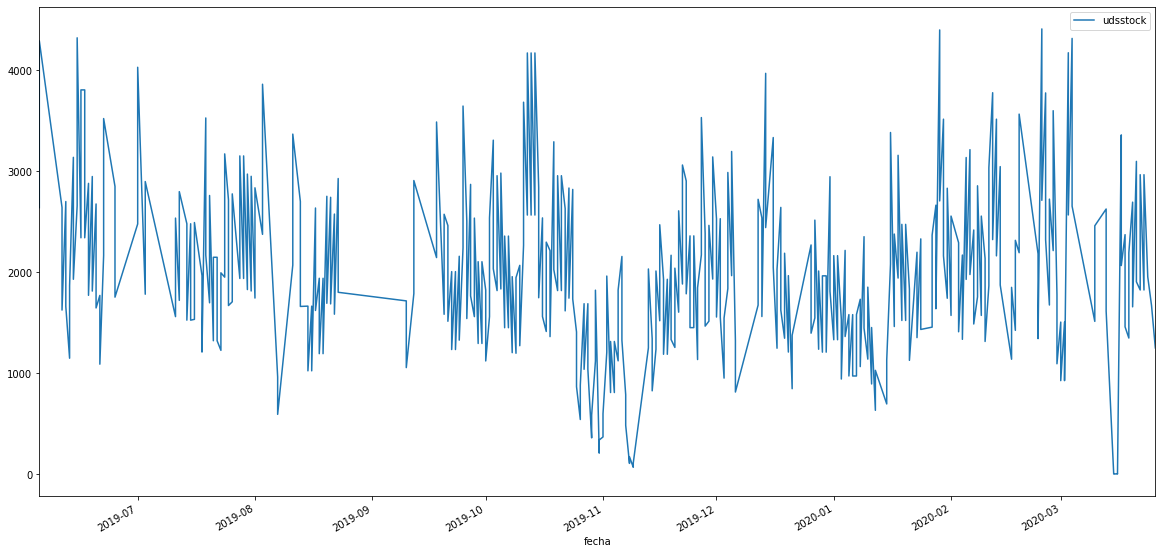

In [12]:
df_38.plot(figsize=(20,10))

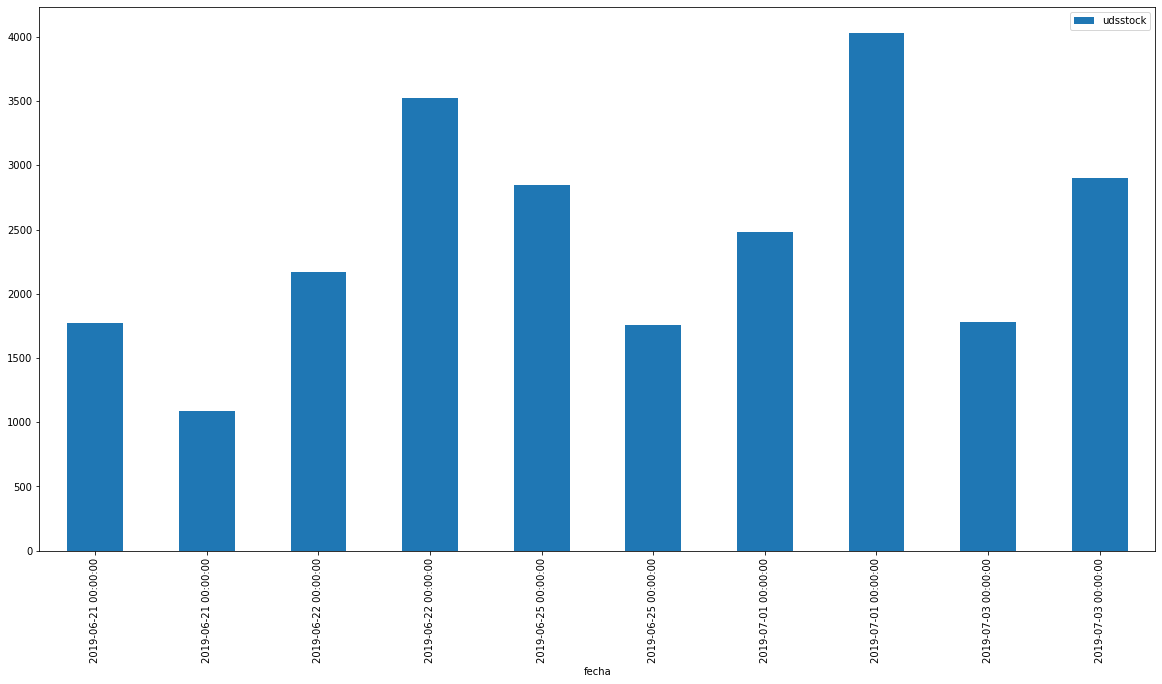

In [26]:
df_38.loc[(df_38.index > '2019-06-20') & (df_38.index < '2019-07-10')].plot(figsize=(20,10), kind='bar')

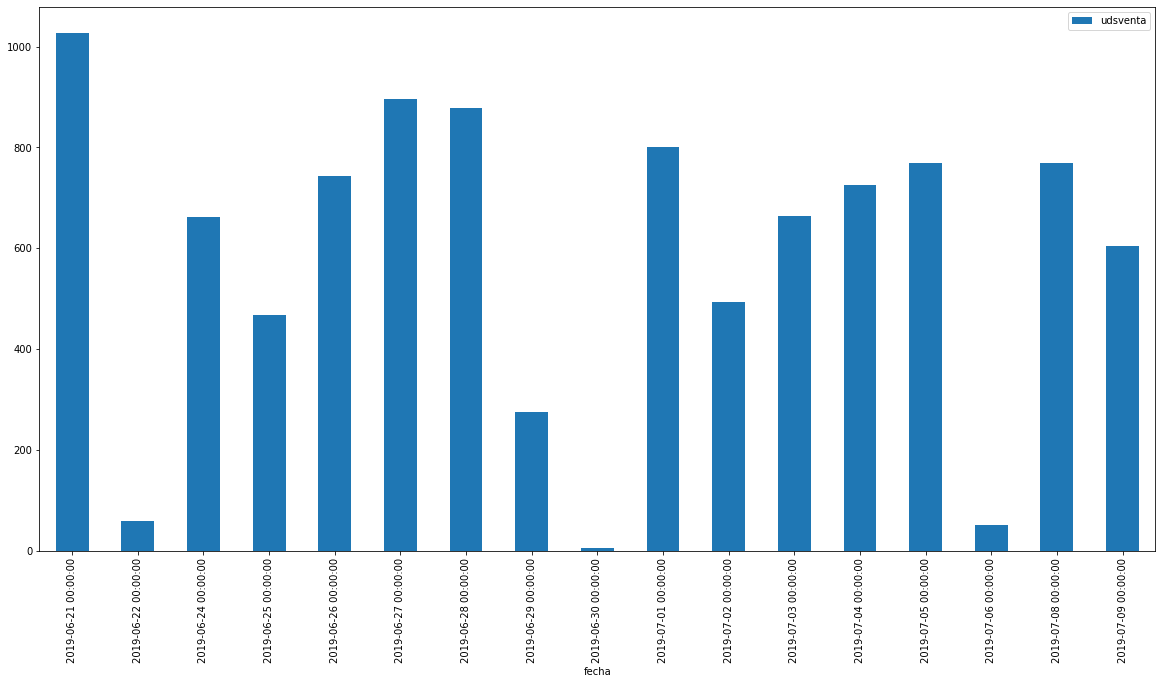

In [27]:
ventas_38 = ventas.loc[ventas.producto == '38', ["fecha", "udsventa"]].set_index("fecha")
ventas_38.loc[(ventas_38.index > '2019-06-20') & (ventas_38.index < '2019-07-10')].plot(figsize=(20,10), kind='bar')

In [22]:
ventas_38.loc[(ventas_38.index > '2019-06-04') & (ventas_38.index < '2019-06-20')]

,udsventa
fecha,
2019-06-05,676
2019-06-06,970
2019-06-07,1102
2019-06-08,103
2019-06-10,772
2019-06-11,396
2019-06-12,772
2019-06-13,763
2019-06-14,878


In [23]:
df_38.loc[df_38.index < '2019-06-20']

,udsstock
fecha,
2019-06-05,2640
2019-06-05,4292
2019-06-11,2642
2019-06-11,1625
2019-06-12,2700
2019-06-12,1661
2019-06-13,1148
2019-06-13,1866
2019-06-14,3138


In [24]:
df_38.median()

udsstock    1883.0
dtype: float64

# Intervalos sin valor

In [75]:
# PRINT EDA FOR STOCK DATA
df = pd.read_csv("data/clean/stock_all.csv", parse_dates= ["fecha"])

variable = "udsstock"

df.dtypes

fecha                  datetime64[ns]
producto                        int64
udsstock                      float64
udsventa                      float64
udsprevisionempresa           float64
promo                         float64
festivo                       float64
weekday                         int64
dtype: object

In [80]:
def get_event_interval(in_df):
    """
    Calculates a new dataframe with the initial time, the final time and the value in the event.
    
    Args:
        df (pd.DataFrame): Streaming dataset where the first column contains the date (in
                           datetime format) and the second column contains the values of each
                           record. Event changes will be specified by changes in the second column.
    Returns:
        pd.DataFrame: a DataFrame with four columns: the initial time, the final time, the 
                      value that the variable catch during the event and the duration of the
                      event in seconds.
    """
    # Ordenamos por la primera columna y copiamos el dataframe
    df = in_df.sort_values(in_df.columns[0]).copy()
    
    inicio_evento = (df.iloc[:,1] != df.iloc[:,1].shift(1))
    t_inicial = df[inicio_evento].iloc[:,0]
    fin_evento = inicio_evento.shift(-1, fill_value=True)
    t_final = df[fin_evento].iloc[:,0]
    value = df[fin_evento].iloc[:,1]
    
    # Calculamos duracion del evento
    duracion = pd.Series(t_final.values - t_inicial.values).dt.total_seconds().astype(np.int)/(24*3600)
    duracion = duracion + 1
    
    # Conformar dataset de salida
    out_df = pd.DataFrame({'start_date': t_inicial.values, 'end_date': t_final.values, 
                           'value': value.values, 'duration': duracion.values})
    
    return out_df

In [92]:
total_missings = []
num_intervalos = []
media_intervalos = []
num_intervalos_1dia = []
products = df.producto.unique()

for product in products:
    subdf = df.loc[df.producto == product, ["fecha", "udsstock"]]
    df_intervals = get_event_interval(subdf.fillna(0))
    res = df_intervals.loc[df_intervals.value == 0]
    total_missings.append(res.duration.sum())
    media_intervalos.append(res.duration.mean())
    num_intervalos.append(res.duration.count())
    num_intervalos_1dia.append(res.loc[res.duration == 1].duration.count())
    
results = pd.DataFrame({"productos":products,
                        "total_missings": total_missings,
                        "num_intervalos": num_intervalos,
                        "media_intervalos": media_intervalos,
                       "num_intervalos_1dia":num_intervalos_1dia})

results.describe()

,productos,total_missings,num_intervalos,media_intervalos,num_intervalos_1dia
count,82.000000,82.000000,82.000000,82.000000,82.000000
mean,49.268293,128.390244,32.182927,9.547144,13.231707
std,28.627902,54.774455,9.275120,34.213425,4.383749
min,1.000000,85.000000,1.000000,2.658537,0.000000
25%,23.250000,93.000000,30.000000,2.865469,12.000000
50%,49.500000,103.000000,32.000000,3.000000,13.000000
75%,72.750000,140.500000,35.500000,3.299425,15.750000
max,99.000000,295.000000,54.000000,295.000000,25.000000


### Numero de intervalos totales y numero de intervalos de 1 dia

In [98]:
results.total_missings.sum()

10528.0

In [96]:
results.num_intervalos.sum()

2639

In [97]:
results.num_intervalos_1dia.sum()

1085

### Numero de missings por intervalo mayor de 5

In [93]:
results.loc[results.media_intervalos > 5]

,productos,total_missings,num_intervalos,media_intervalos,num_intervalos_1dia
32,44,229.0,19,12.052632,10
41,53,203.0,30,6.766667,6
42,54,232.0,20,11.600000,11
45,58,221.0,32,6.906250,7
56,7,282.0,5,56.400000,1
57,70,295.0,1,295.000000,0
58,71,225.0,21,10.714286,8
63,76,240.0,16,15.000000,5
67,80,279.0,9,31.000000,2
68,82,160.0,20,8.000000,9


In [95]:
results.loc[results.total_missings == num_intervalos_1dia]

,productos,total_missings,num_intervalos,media_intervalos,num_intervalos_1dia
